## Final Project Submission
Please fill out:

* Student name: Arseniy Tyurin
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name: Eli Thomas
* Blog post URL:

# Introduction

This project is about building and optimization of classification models. Essentially I'm going to do exploratory data analysis and build and tune classification models to predict which client will subscribe to the term deposit and what features have biggest effect on persons decision.

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Source:
<a href="https://www.kaggle.com/henriqueyamahata/bank-marketing">Kaggle</a> or <a href="https://archive.ics.uci.edu/ml/datasets/Bank+Marketing">UCI</a>

## Dataset Description:
- **age** (numeric)
- **job**: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- **education** (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- **default**: has credit in default? (categorical: 'no','yes','unknown')
- **housing**: has housing loan? (categorical: 'no','yes','unknown')
- **loan**: has personal loan? (categorical: 'no','yes','unknown')
- **contact**: contact communication type (categorical: 'cellular','telephone') 
- **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client (numeric)
- **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
- **cons.price.idx**: consumer price index - monthly indicator (numeric)     
- **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)     
- **euribor3m**: euribor 3 month rate - daily indicator (numeric)
- **nr.employed**: number of employees - quarterly indicator (numeric)
- **y** - has the client subscribed a term deposit? (binary: 'yes','no')

# Data Science Process

A successful completion of the analysis requires clear understanding of business problem.
For this project I'm going to use <a href="https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492" target="_blank">OSEMN Framework</a> (Obtain-Scrab-Explore-Model-Interpret), which is one of the most common ways of doing analysis and building predictive models.

# Importing Libraries

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Data Import and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load # save/load trained model
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Validation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import calinski_harabaz_score

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb 
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-whitegrid')

## Supporting Functions

In [3]:
def conf_matrix(cnf_matrix):
    '''
    Visualization function for confusion matrix
    '''
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) # Create the basic matrix.

    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.style.use('seaborn-white')
    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    
def plot_feature_importances(model):
    '''
    Visualization for future importance
    '''
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

# 1. Obtain

This is a simple step because I already have all the data I need in .csv file.

In [4]:
# Reading data into 'bank' dataframe
bank = pd.read_csv('assets/bank/bank-additional-full.csv', sep=';')

To make sure data is loaded properly I would look at top 5 rows

In [5]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Data is loaded correctly, I'm going to the next step of cleaning and transforming data

# 2. Scrub

### Checking for null values

In [6]:
bank.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values in the entire dataset

### Checking for data types

In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

# 3. Explore

### Target Variable

Most important thing I need is to figure out my target variable to make a decision

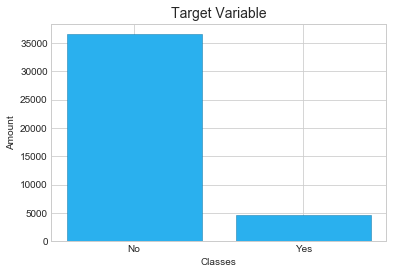

In [8]:
plt.bar(['No', 'Yes'], bank.y.value_counts().values, facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Target Variable', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

In [9]:
bank.y.replace({'yes': 1, 'no': 0}, inplace=True)

Target variable is extremely inbalanced. This is important to remember when performing classification and evaluation, because even without using of machine learning I can make predictions with roughly 90% accuracy just by guessing none of the clients subscribed to the term deposit. Since we are focused only on the clients that said 'Yes', chances to get predictions are very thin.

### Previous results of marketing campaign

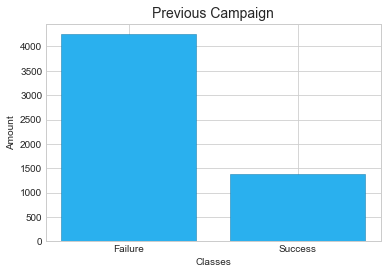

In [10]:
plt.bar(['Failure', 'Success'], [sum(bank.poutcome=='failure'), sum(bank.poutcome=='success')], \
        facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Previous Campaign', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

### Returned clients that subscribed to the new term deposit

In [11]:
returned_customers = len(bank[(bank.poutcome=='success') & (bank.y==1)])/len(bank[bank.poutcome=='success'])
print('Returned clients who has subscribed to the new term deposit: {}%'.format(round(returned_customers*100)))

Returned clients who has subscribed to the new term deposit: 65%


### Euro Interbank Offered Rate

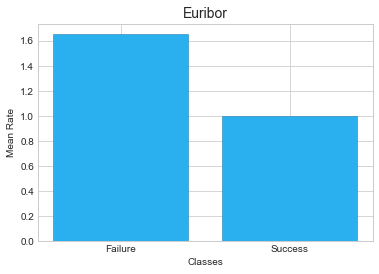

In [13]:
plt.bar(['Failure', 'Success'], [bank[bank.poutcome=='failure'].euribor3m.mean(), bank[bank.poutcome=='success'].euribor3m.mean()], \
        facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Euribor', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Mean Rate')
plt.show()

In [156]:
bank[bank.y==1].euribor3m.mean(), bank[bank.y==0].euribor3m.mean()

(2.123135129310348, 3.811491162306908)

### Job distribution

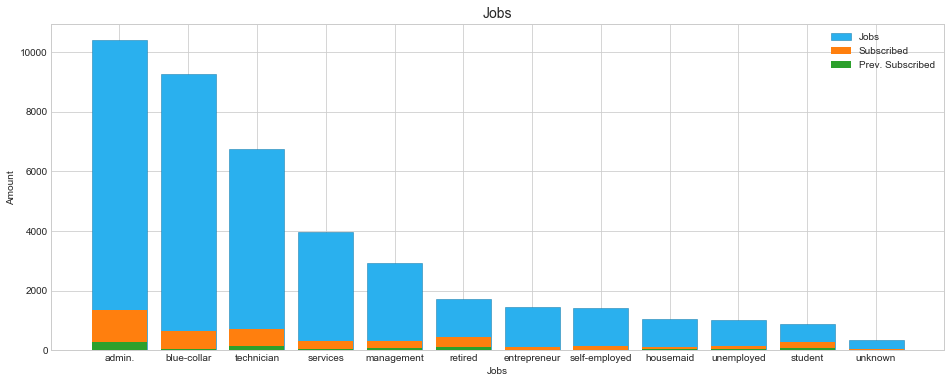

In [15]:
plt.figure(figsize=(16,6))
plt.bar(bank.job.value_counts().keys(), bank.job.value_counts().values, label='Jobs', facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.bar(bank.job.value_counts().keys(), [bank[bank.job==i].y.sum() for i in bank.job.value_counts().keys()], label='Subscribed')
plt.bar(bank.job.value_counts().keys(), [bank[(bank.poutcome=='success') & (bank.job==i)].y.sum() for i in bank.job.value_counts().keys()], label='Prev. Subscribed')
plt.title('Jobs', fontsize=14)
plt.xlabel('Jobs')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Education Distribution

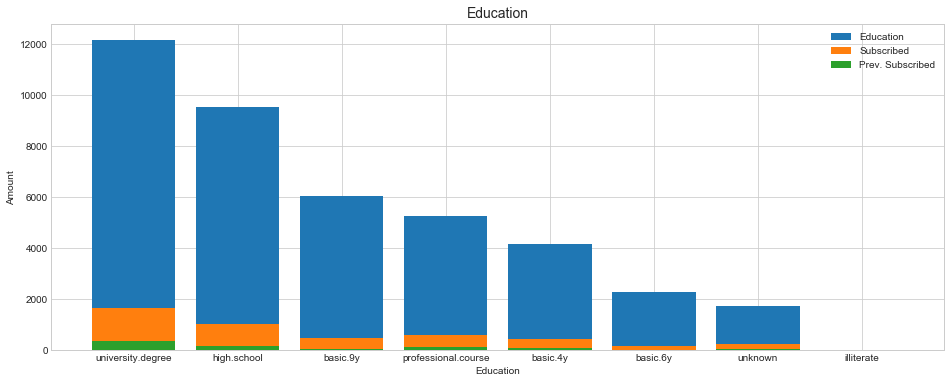

In [16]:
plt.figure(figsize=(16,6))
plt.bar(bank.education.value_counts().keys(), bank.education.value_counts().values, label='Education')
plt.bar(bank.education.value_counts().keys(), [bank[bank.education==i].y.sum() for i in bank.education.value_counts().keys()], label='Subscribed')
plt.bar(bank.education.value_counts().keys(), [bank[(bank.poutcome=='success')&(bank.education==i)].y.sum() for i in bank.education.value_counts().keys()], label='Prev. Subscribed')
plt.title('Education', fontsize=14)
plt.xlabel('Education')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Marital Status Distribution

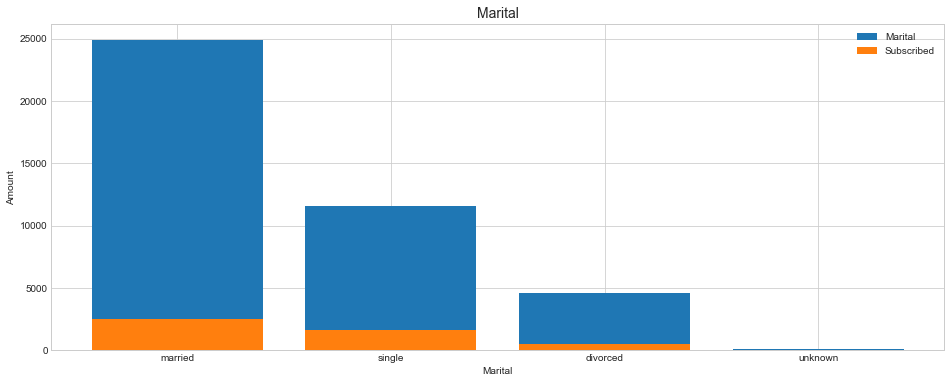

In [17]:
plt.figure(figsize=(16,6))
plt.bar(bank.marital.value_counts().keys(), bank.marital.value_counts().values, label='Marital')
plt.bar(bank.marital.value_counts().keys(), [bank[bank.marital==i].y.sum() for i in bank.marital.value_counts().keys()], label='Subscribed')
plt.title('Marital', fontsize=14)
plt.xlabel('Marital')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Age Distribution

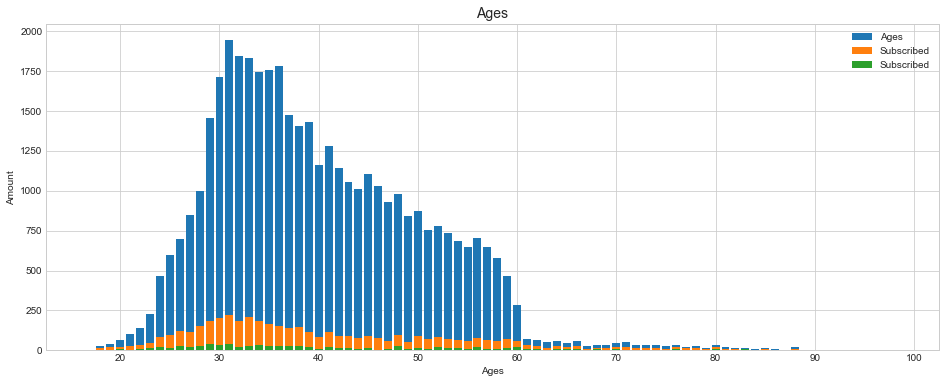

In [18]:
plt.figure(figsize=(16,6))
plt.bar(bank.groupby('age').y.sum().keys(), [sum(bank.age==i) for i in bank.groupby('age').y.sum().keys()], label='Ages')
plt.bar(bank.groupby('age').y.sum().keys(), [bank[bank.age==i].y.sum() for i in bank.groupby('age').y.sum().keys()], label='Subscribed')
plt.bar(bank.groupby('age').y.sum().keys(), [bank[(bank.poutcome=='success')&(bank.age==i)].y.sum() for i in bank.groupby('age').y.sum().keys()], label='Subscribed')
plt.title('Ages', fontsize=14)
plt.xlabel('Ages')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Age After 60

There is substential drop in number of clients after 60 years old, but as you can see proportion of subscribed clients are higher. Lets compare groups before/after 60 y.o.

In [50]:
before_60 = round((bank[bank.age < 60].y.sum()/sum(bank.age < 60))*100, 2)
after_60 = round((bank[bank.age > 60].y.sum()/sum(bank.age > 60))*100, 2)

print('Before 60: {}% subscribed\nAfter 60: {}% subscribed'.format(before_60, after_60))

Before 60: 10.42% subscribed
After 60: 45.49% subscribed


There is an evidence that clients who are over 60 years old are more willing to subscribe to the term deposit.

### Distribution of contacts made each month of the campaign

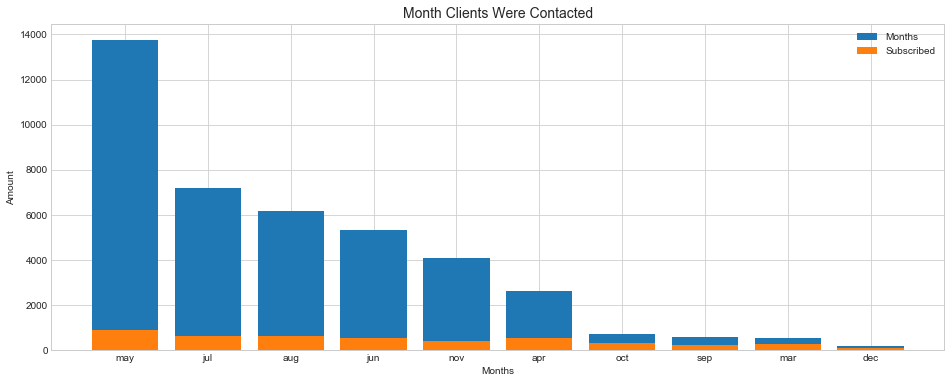

In [21]:
plt.figure(figsize=(16,6))
plt.bar(bank.month.value_counts().keys(), bank.month.value_counts().values, label='Months')
plt.bar(bank.month.value_counts().keys(), [bank[bank.month==i].y.sum() for i in bank.month.value_counts().keys()], label='Subscribed')
plt.title('Month Clients Were Contacted', fontsize=14)
plt.xlabel('Months')
plt.ylabel('Amount')
plt.legend()
plt.show()

### Number of contacts performed during recent campaign to each client

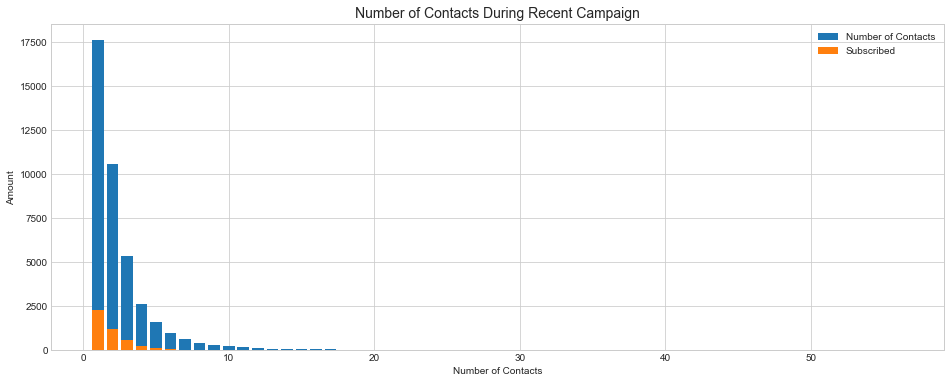

In [24]:
plt.figure(figsize=(16,6))
plt.bar(bank.campaign.value_counts().keys(), bank.campaign.value_counts().values, label='Number of Contacts')
plt.bar(bank.campaign.value_counts().keys(), [bank[bank.campaign==i].y.sum() for i in bank.campaign.value_counts().keys()], label='Subscribed')
plt.title('Number of Contacts During Recent Campaign', fontsize=14)
plt.xlabel('Number of Contacts')
plt.ylabel('Amount')
plt.legend()
plt.show()

# 4. Model

## Dealing with categorical values

In [25]:
bank = pd.get_dummies(bank, columns=['housing','loan','job','marital', \
                                     'education','contact','month','day_of_week','poutcome','default'])

## Separating features and target variable

In [26]:
X = bank.drop(['y','duration','campaign'], axis=1)
y = bank.y

## Scaling

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Splitting Data into Train and Test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

## SMOTE: Synthetic Minority Over-sampling Technique

In [29]:
smote = SMOTE(random_state=0)

In [30]:
X_res, y_res = smote.fit_resample(X_train, y_train)

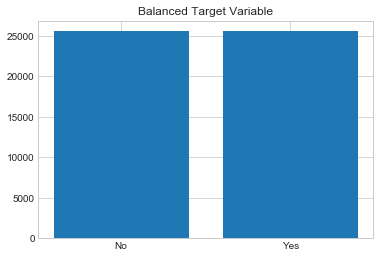

In [31]:
plt.bar(['No','Yes'], [sum(y_res), len(y_res)-sum(y_res)])
plt.title('Balanced Target Variable')
plt.show()

## Logistic Regression

I start my analysis with simple logistic regression as a benchmark. One of the features of logistic regression is the **decision function**. It predicts confidence scores for samples. Basically it shows balance between true positive / false positive rates.

AUC: 0.7996767918841073


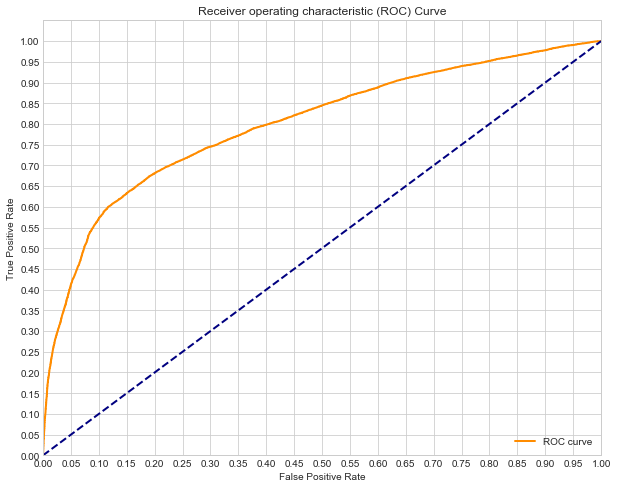

In [58]:
plt.style.use('seaborn-whitegrid')
logreg = LogisticRegression(fit_intercept=False, n_jobs=-1)

#Probability scores for test set
y_score = logreg.fit(X_res, y_res).decision_function(X_res)
y_pred = logreg.fit(X_res, y_res).predict(X_test)
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_res, y_score)

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Evaluation of Logistic Regression

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84     10969
           1       0.27      0.69      0.38      1388

   micro avg       0.75      0.75      0.75     12357
   macro avg       0.61      0.72      0.61     12357
weighted avg       0.87      0.75      0.79     12357



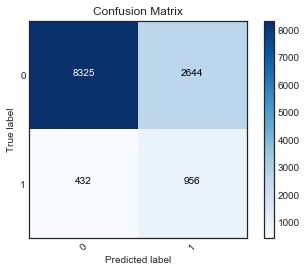

In [34]:
plt.style.use('seaborn-white')
logreg = LogisticRegression(fit_intercept=False, n_jobs=-1)
y_pred = logreg.fit(X_res, y_res).predict(X_test)
conf_matrix(confusion_matrix(y_test, y_pred))

Model accurately identified true positives 956 times out of 1388, but it also got 2644 false positives, which made f1-score very low. My next step would be try different models and see which one is the best fit for my problem

## Classifiers with default parameters

At this step I will compare different models

In [35]:
logistic_regression = LogisticRegression(n_jobs=-1)
random_forest = RandomForestClassifier(n_jobs=-1)
adaboost = AdaBoostClassifier()
gboost = GradientBoostingClassifier()
xgboost = xgb.XGBClassifier(n_jobs=-1)
naive_bayes = GaussianNB()

classifiers = [logistic_regression, random_forest, xgboost, adaboost, gboost, naive_bayes]
classifiers_names = ['Logistic Regression', 'Random Forest','XGBoost', 'AdaBoost', 'Gradient Boost','Naive Bayes']

In [36]:
scores = []
for i in range(len(classifiers)):
    y_pred = classifiers[i].fit(X_res, y_res).predict(X_test)
    scores.append(round(f1_score(y_test, y_pred), 3))

pd.DataFrame({'Classifier': classifiers_names, 'F1-Score': scores}).sort_values('F1-Score', ascending=False)

,Classifier,F1-Score
4,Gradient Boost,0.485
2,XGBoost,0.483
3,AdaBoost,0.464
0,Logistic Regression,0.438
1,Random Forest,0.380
5,Naive Bayes,0.323


**Gradient Boost** and **XGBoost** has shown the best performance and are pretty close on F1-Score. I will keep both of them for now.

## Gradient Boost Tuning With GridSearch

In [37]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'subsample': [0.5]
}

In [38]:
grid = GridSearchCV(gboost, param_grid, n_jobs=-1)

In [39]:
grid.fit(X_res, y_res).best_params_

{'max_depth': 12, 'n_estimators': 100, 'subsample': 0.5}

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10969
           1       0.53      0.34      0.41      1388

   micro avg       0.89      0.89      0.89     12357
   macro avg       0.72      0.65      0.68     12357
weighted avg       0.88      0.89      0.88     12357



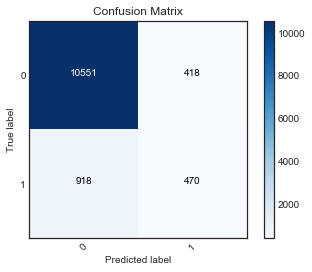

In [40]:
gboost = GradientBoostingClassifier(max_depth=12, n_estimators=100, subsample=0.5)
y_pred = gboost.fit(X_res, y_res).predict(X_test)

conf_matrix(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## XGBoost Tuning With GridSearch

In [67]:
param_grid = {
    'max_depth': [7, 10, 11], 
    'n_estimators': [15, 20, 50, 70], 
    'min_child_weight': [2, 3], 
    'subsample': [0.5],
}
gridsearch = GridSearchCV(xgboost, param_grid, n_jobs=-1)

In [68]:
gridsearch.fit(X_res, y_res).best_params_

{'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 70, 'subsample': 0.5}

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10969
           1       0.56      0.35      0.43      1388

   micro avg       0.90      0.90      0.90     12357
   macro avg       0.74      0.66      0.69     12357
weighted avg       0.88      0.90      0.89     12357



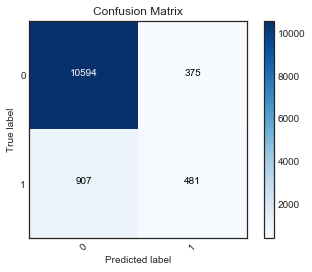

In [84]:
xgboost = xgb.XGBClassifier(max_depth=11, 
                            learning_rate=0.1, 
                            n_estimators=70, 
                            min_child_weight=2, 
                            subsample=0.5, 
                            n_jobs=-1)
y_pred = xgboost.fit(X_res, y_res).predict(X_test)

print(classification_report(y_test, y_pred))
conf_matrix(confusion_matrix(y_test, y_pred))
#plot_feature_importances(xgboost)

## Predicting On The Entire Dataset

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     36548
           1       0.70      0.45      0.54      4640

   micro avg       0.92      0.92      0.92     41188
   macro avg       0.82      0.71      0.75     41188
weighted avg       0.91      0.92      0.91     41188



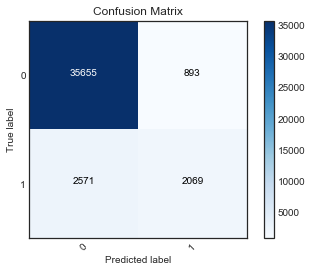

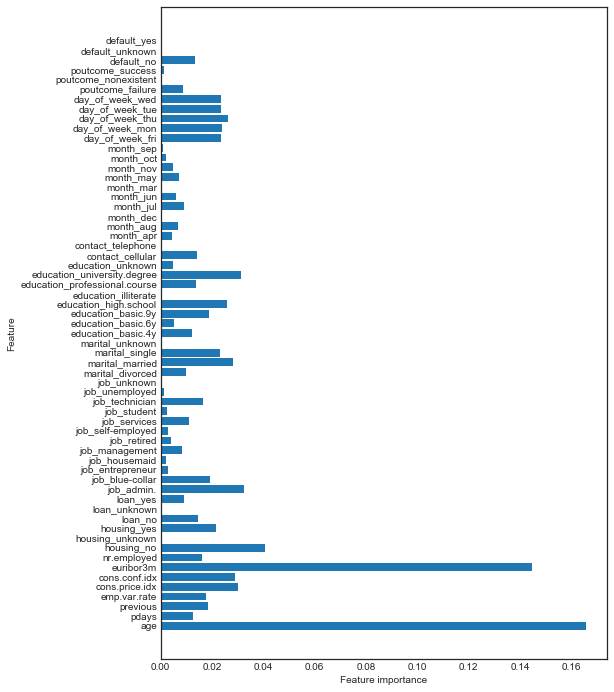

In [129]:
xgboost = xgb.XGBClassifier(max_depth=11, 
                            learning_rate=0.1, 
                            n_estimators=70, 
                            min_child_weight=3, 
                            subsample=0.7, 
                            n_jobs=-1)
y_pred = xgboost.fit(X_res, y_res).predict(X_scaled)

print(classification_report(y, y_pred))
conf_matrix(confusion_matrix(y, y_pred))
plot_feature_importances(xgboost)

## Cross Evaluation

In [132]:
cross_val_score(xgboost, X_scaled, y, cv=10).mean()

0.3648291638471358

# 5. Interpret

- Most important factor is Euro Interbank Offered Rate (Euribor)
- 11% of clients subscribed to the new term deposit
- 65% of previous clients subscribed to the new term deposit
- 45% of clients who are over 60 y.o has subscribed to the term deposit
- XGBoost Model showed best performance